### Imports

In [1]:
import numpy as np
import IPython.display as ipd
import math
import IPython
import sys
import pyaudio

import time
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import wave
import random

In [2]:
def sinewave(t, freq):
    return np.sin(2 * np.pi * freq * t).astype(np.float32)

def sawtooth(t, frequency):
  return 2 * ( (t*frequency) - np.floor(0.5 + (t*frequency))).astype(np.float32)
  
def pulse(t, frequency):
  return np.round(np.sin(2 * np.pi * frequency * t) > 0).astype(np.float32)

def triangle(t, frequency):
  return (2 * np.abs(2.0 *((t*frequency) - np.floor(0.5 + (t*frequency)))) - 1.0).astype(np.float32)

def noise(t, freq):
  t = np.copy(t)
  t *= 0
  t += np.random.normal(0,1,t.shape)
  return t

def load_wavefile(filename):
  # Open wave file
  wave_file = wave.open(filename, 'rb')

  # Get parameters
  nchannels = wave_file.getnchannels()
  sampwidth = wave_file.getsampwidth()
  framerate = wave_file.getframerate()
  nframes = wave_file.getnframes()

  # Read wave data
  wave_data = wave_file.readframes(nframes)

  # Convert wave data to numpy array
  if sampwidth == 2:
    # 16-bit samples are stored as signed integers
    wave_data = np.frombuffer(wave_data, dtype=np.int16)
    print("16 int") # ensure type is correct
  elif sampwidth == 4:
    # 32-bit samples are stored as floats
    wave_data = np.frombuffer(wave_data, dtype=np.int32)
    print("32 float") # ensure type is correct

  # If stereo, average the channels
  if nchannels == 2:
    wave_data = np.mean(wave_data.reshape((-1, 2)), axis=1)
  
  return wave_data, framerate

In [31]:
# Load wave file
yamaha_audio, srate = load_wavefile('./Audio Samples/Yamaha_24MX/Yamaha_24MX_Single_Repeat.wav')
yamaha_audio_deaccelerate, srate = load_wavefile('./Audio Samples/Yamaha_24MX/Yamaha_24MX_Single_Repeat_deacceleration.wav')

frame_clock = 0.0
max_speed = 1.3
min_speed = 0.9
alpha = 0.001
beta  = 4
speed = min_speed
speed_variation = 0.001
duration = 10

sample_lerp = 1.0 # a value of 1 is acceleration only, a value of 0 is deacceleration only. 0.5 is 50% each
sample_lerp_rate = 0.01

# Define callback for playback
def callback(in_data, frame_count, time_info, status):

    global frame_clock
    global yamaha_audio
    global speed
    global alpha 
    global sample_lerp

    data = np.zeros(frame_count).astype(np.int16) # ensure type is correct

    if alpha < 0:
        sample_lerp -= sample_lerp_rate
    else:
        sample_lerp += sample_lerp_rate

    # Clamp sample lerp between 0 and 1
    sample_lerp = max(min(sample_lerp, 1.0), 0.0)

    # We lerp between the two samples when because when we start deaccelerating we don't want to create a popping effect
    audio_sample = yamaha_audio_deaccelerate + (yamaha_audio - yamaha_audio_deaccelerate) * sample_lerp

    for i in range(frame_count):

        frame_lower = math.floor(frame_clock)
        frame_upper = math.ceil(frame_clock)

        lower_to_upper_ratio = frame_clock - math.floor(frame_clock)

        lower_value = audio_sample[frame_lower % yamaha_audio.shape[0]]
        upper_value = audio_sample[frame_upper % yamaha_audio.shape[0]]

        interpolated_value = lower_value + (upper_value - lower_value) * lower_to_upper_ratio

        data[i] = interpolated_value
        frame_clock += speed

    speed += alpha * math.pow(speed, beta)
    speed += speed_variation * (random.random() - 0.5)

    if speed > max_speed:
        alpha = -abs(alpha)

    if speed < min_speed:
        alpha = abs(alpha)

    return (data, pyaudio.paContinue)

# Instantiate PyAudio and initialize PortAudio system resources
p = pyaudio.PyAudio()


# Open stream using callback
stream = p.open(format=pyaudio.paInt16, # ensure type is correct
                channels=1,
                rate=srate,
                output=True,
                stream_callback=callback)

# Wait until audio stream is completed
time.sleep(duration)

# Close the stream 
stream.close()

# Release PortAudio system resources
p.terminate()

16 int
16 int


#### Used to close stream incase of error

In [30]:
# Close the stream 
stream.close()

# Release PortAudio system resources
p.terminate()

Deacceleration audio filtering \
\
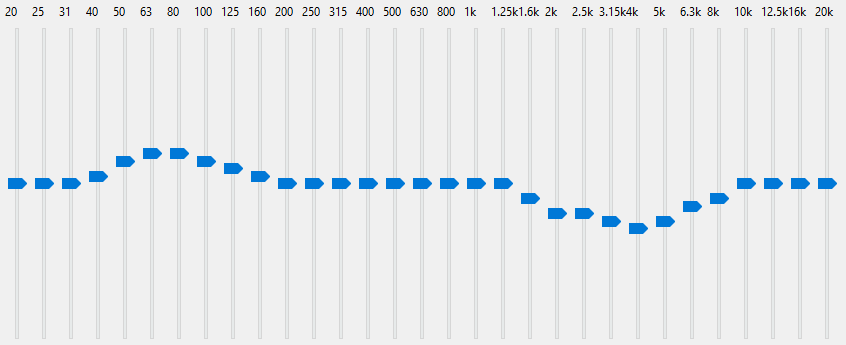

Acceleration qudio filtering \
\
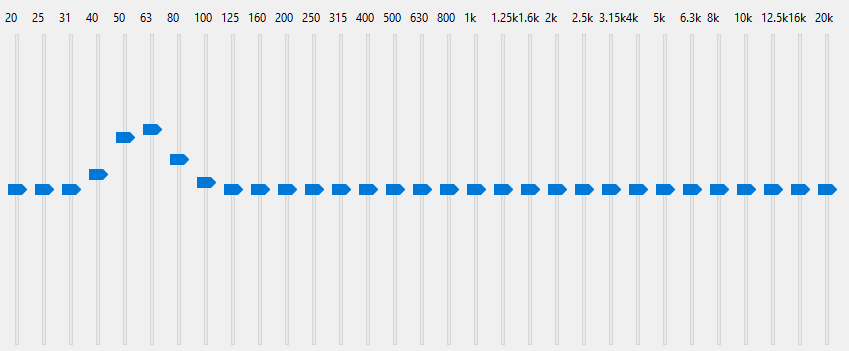